In [1]:
#Importing the necessary modules for the analysis
import os
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_text

## Loading the data into the pandas dataframe

In [2]:
#reading the data using the pandas module
df=pd.read_csv("eth_15min.csv")
df=df.rename(columns={'Unnamed: 0': 'timestamp'}) #setting the timestamp as index
df=df.set_index("timestamp")

## visualization of the final target 

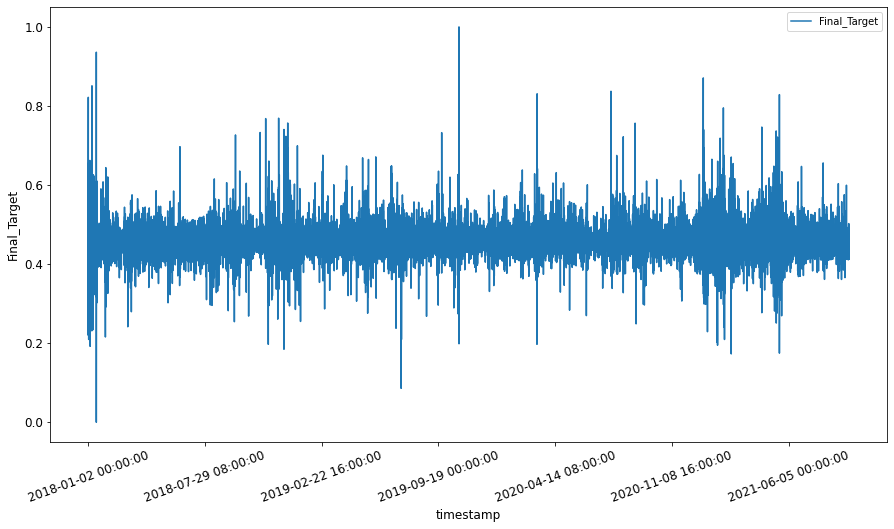

In [4]:
df.plot(y='Final_Target', subplots=True, figsize=(15, 8), fontsize=12)
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('Final_Target', fontsize=12)
plt.xticks(rotation=20)
plt.show()

In [6]:
# univariate data: Final_target vs Time

uni_data_df = df['Final_Target']
uni_data_df.head()
uni_data_df.shape

(130370,)

In [7]:
uni_data_df.shape

(130370,)

In [8]:
#splitting the data into 70-30
train_start_dt = '2018-01-02'
test_start_dt = '2020-08-11'

## Data visualisation of train and test 

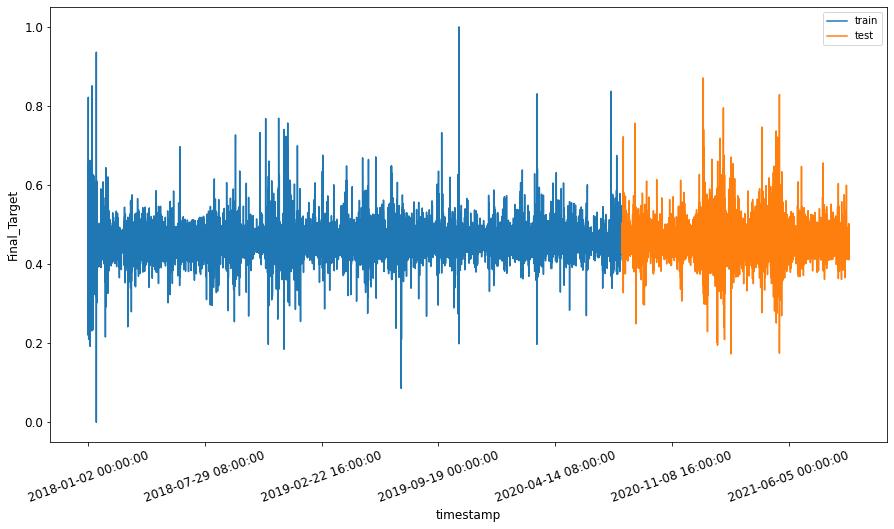

In [9]:
df[(df.index < test_start_dt) & (df.index >= train_start_dt)][['Final_Target']].rename(columns={'Final_Target':'train'}) \
    .join(df[test_start_dt:][['Final_Target']].rename(columns={'Final_Target':'test'}), how='outer') \
    .plot(y=['train', 'test'], figsize=(15, 8), fontsize=12)
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('Final_Target', fontsize=12)
plt.xticks(rotation=20)
plt.show()

In [11]:
train = df.copy()[(df.index >= train_start_dt) & (df.index < test_start_dt)][['Final_Target']]
test = df.copy()[df.index >= test_start_dt][['Final_Target']]

print('Training data shape: ', train.shape)
print('Test data shape: ', test.shape)

Training data shape:  (91392, 1)
Test data shape:  (38978, 1)


In [12]:
train.head(10)

,Final_Target
timestamp,
2018-01-02 00:00:00,0.546330
2018-01-02 00:15:00,0.550354
2018-01-02 00:30:00,0.635160
2018-01-02 00:45:00,0.532988
2018-01-02 01:00:00,0.566638
2018-01-02 01:15:00,0.573950
2018-01-02 01:30:00,0.734319
2018-01-02 01:45:00,0.751294
2018-01-02 02:00:00,0.683291


In [13]:
test.shape

(38978, 1)

In [14]:
test.head(10)

,Final_Target
timestamp,
2020-08-11 00:00:00,0.427689
2020-08-11 00:15:00,0.461544
2020-08-11 00:30:00,0.441716
2020-08-11 00:45:00,0.467855
2020-08-11 01:00:00,0.462050
2020-08-11 01:15:00,0.479041
2020-08-11 01:30:00,0.458920
2020-08-11 01:45:00,0.444222
2020-08-11 02:00:00,0.466103


In [15]:
# Converting to numpy arrays
train_data = train.values
test_data = test.values

In [16]:
#using the previous past 4 time steps to predict the next time step i.e 5th min target value
timesteps=5

In [17]:
train_data_timesteps=np.array([[j for j in train_data[i:i+timesteps]] for i in range(0,len(train_data)-timesteps+1)])[:,:,0]
train_data_timesteps.shape

(91388, 5)

In [18]:
train_data_timesteps

array([[0.54632988, 0.55035361, 0.63515959, 0.53298773, 0.56663839],
       [0.55035361, 0.63515959, 0.53298773, 0.56663839, 0.57395036],
       [0.63515959, 0.53298773, 0.56663839, 0.57395036, 0.73431893],
       ...,
       [0.46315553, 0.45774441, 0.45223693, 0.45438962, 0.44349477],
       [0.45774441, 0.45223693, 0.45438962, 0.44349477, 0.44573861],
       [0.45223693, 0.45438962, 0.44349477, 0.44573861, 0.4606606 ]])

In [19]:
test_data_timesteps=np.array([[j for j in test_data[i:i+timesteps]] for i in range(0,len(test_data)-timesteps+1)])[:,:,0]
test_data_timesteps.shape

(38974, 5)

In [20]:
test_data_timesteps

array([[0.42768886, 0.46154377, 0.44171578, 0.46785507, 0.4620502 ],
       [0.46154377, 0.44171578, 0.46785507, 0.4620502 , 0.47904068],
       [0.44171578, 0.46785507, 0.4620502 , 0.47904068, 0.45891978],
       ...,
       [0.41220745, 0.45940606, 0.49019406, 0.45569509, 0.4476771 ],
       [0.45940606, 0.49019406, 0.45569509, 0.4476771 , 0.45339031],
       [0.49019406, 0.45569509, 0.4476771 , 0.45339031, 0.45339031]])

In [21]:
x_train, y_train = train_data_timesteps[:,:timesteps-1],train_data_timesteps[:,[timesteps-1]]
x_test, y_test = test_data_timesteps[:,:timesteps-1],test_data_timesteps[:,[timesteps-1]]

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(91388, 4) (91388, 1)
(38974, 4) (38974, 1)


In [22]:
x_train,y_train

(array([[0.54632988, 0.55035361, 0.63515959, 0.53298773],
        [0.55035361, 0.63515959, 0.53298773, 0.56663839],
        [0.63515959, 0.53298773, 0.56663839, 0.57395036],
        ...,
        [0.46315553, 0.45774441, 0.45223693, 0.45438962],
        [0.45774441, 0.45223693, 0.45438962, 0.44349477],
        [0.45223693, 0.45438962, 0.44349477, 0.44573861]]),
 array([[0.56663839],
        [0.57395036],
        [0.73431893],
        ...,
        [0.44349477],
        [0.44573861],
        [0.4606606 ]]))

In [23]:
x_test, y_test

(array([[0.42768886, 0.46154377, 0.44171578, 0.46785507],
        [0.46154377, 0.44171578, 0.46785507, 0.4620502 ],
        [0.44171578, 0.46785507, 0.4620502 , 0.47904068],
        ...,
        [0.41220745, 0.45940606, 0.49019406, 0.45569509],
        [0.45940606, 0.49019406, 0.45569509, 0.4476771 ],
        [0.49019406, 0.45569509, 0.4476771 , 0.45339031]]),
 array([[0.4620502 ],
        [0.47904068],
        [0.45891978],
        ...,
        [0.4476771 ],
        [0.45339031],
        [0.45339031]]))

In [24]:
# Train the model
model = DecisionTreeRegressor().fit(x_train, y_train)
print (model, "\n")

# Visualize the model tree
tree = export_text(model)
print(tree)

DecisionTreeRegressor() 

|--- feature_3 <= 0.49
|   |--- feature_3 <= 0.42
|   |   |--- feature_3 <= 0.36
|   |   |   |--- feature_0 <= 0.34
|   |   |   |   |--- feature_3 <= 0.30
|   |   |   |   |   |--- feature_2 <= 0.29
|   |   |   |   |   |   |--- value: [0.63]
|   |   |   |   |   |--- feature_2 >  0.29
|   |   |   |   |   |   |--- feature_2 <= 0.32
|   |   |   |   |   |   |   |--- value: [0.66]
|   |   |   |   |   |   |--- feature_2 >  0.32
|   |   |   |   |   |   |   |--- value: [0.66]
|   |   |   |   |--- feature_3 >  0.30
|   |   |   |   |   |--- feature_3 <= 0.34
|   |   |   |   |   |   |--- feature_2 <= 0.57
|   |   |   |   |   |   |   |--- feature_0 <= 0.34
|   |   |   |   |   |   |   |   |--- feature_3 <= 0.31
|   |   |   |   |   |   |   |   |   |--- value: [0.45]
|   |   |   |   |   |   |   |   |--- feature_3 >  0.31
|   |   |   |   |   |   |   |   |   |--- feature_3 <= 0.32
|   |   |   |   |   |   |   |   |   |   |--- value: [0.51]
|   |   |   |   |   |   |   |   |   |--

In [25]:
model.fit(x_train, y_train[:,0])

DecisionTreeRegressor()

In [26]:
y_train_pred = model.predict(x_train).reshape(-1,1)
y_test_pred = model.predict(x_test).reshape(-1,1)

print(y_train_pred.shape, y_test_pred.shape)

(91388, 1) (38974, 1)


In [27]:
train_timestamps = df[(df.index < test_start_dt) & (df.index >= train_start_dt)].index[timesteps-1:]
test_timestamps = df[test_start_dt:].index[timesteps-1:]

print(len(train_timestamps), len(test_timestamps))

91388 38974


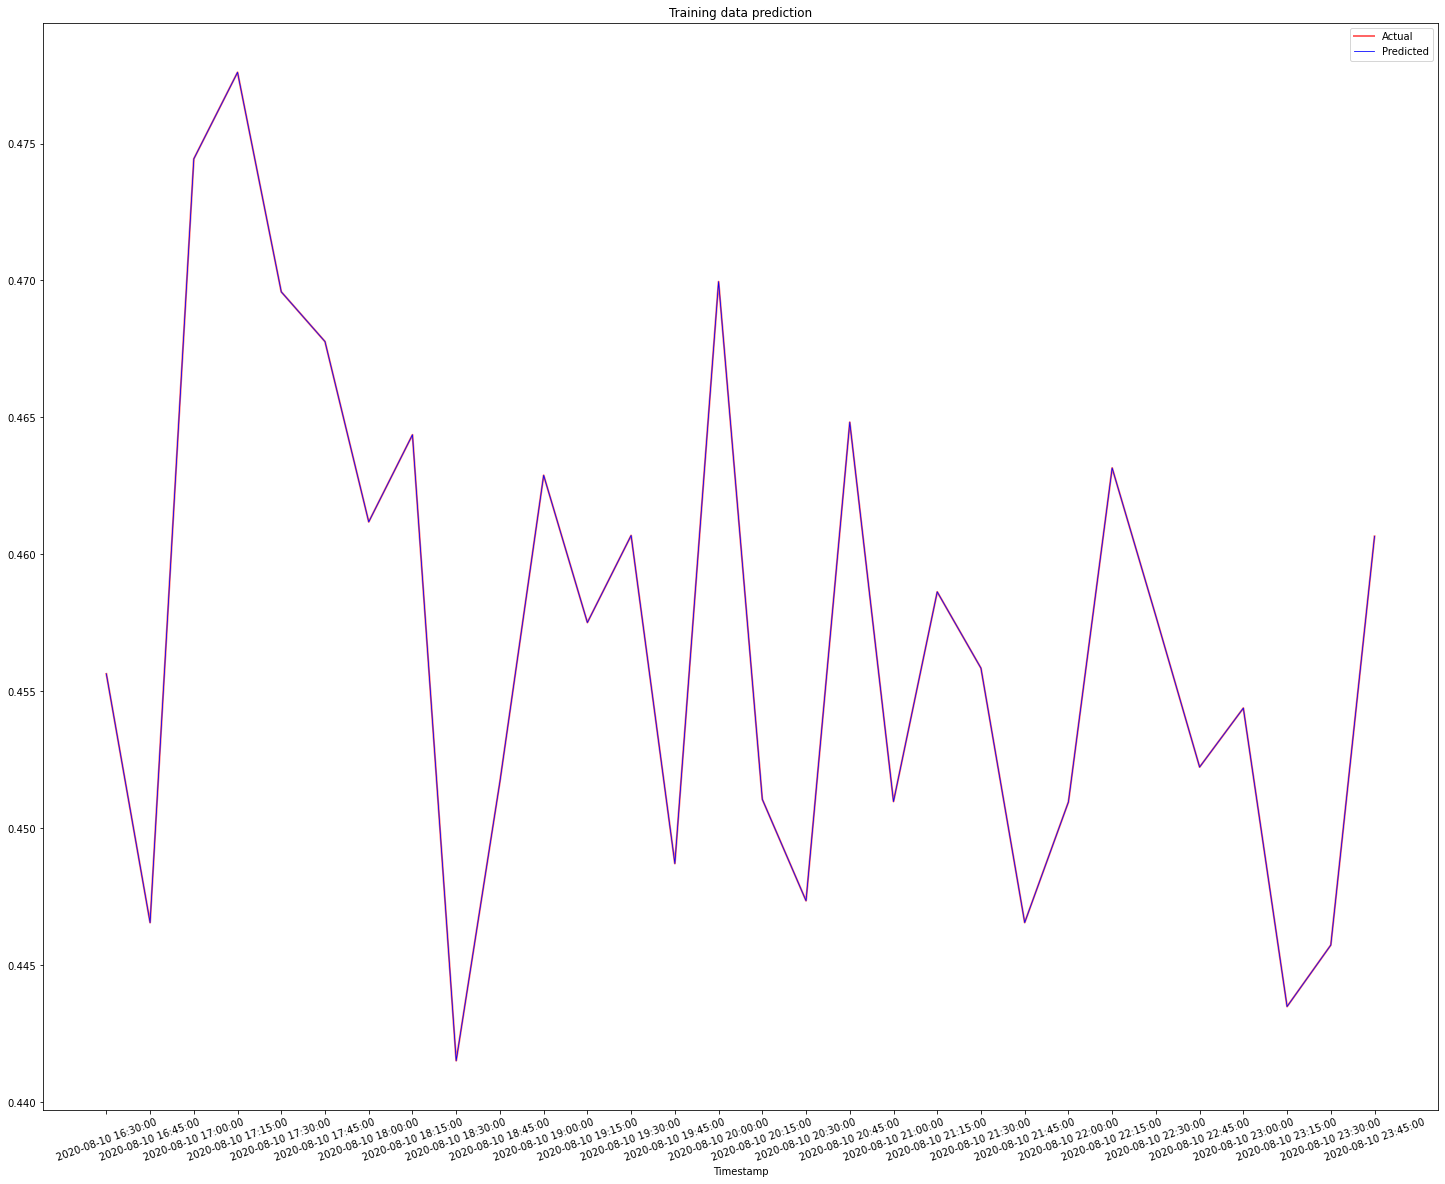

In [28]:
#Visulising the actual vs predicted for the last 30 values in the Train data
plt.figure(figsize=(25,20))
plt.plot(train_timestamps[-30:], y_train[-30:], color = 'red', linewidth=2.0, alpha = 0.6)
plt.plot(train_timestamps[-30:], y_train_pred[-30:], color = 'blue', linewidth=0.8)
plt.legend(['Actual','Predicted'])
plt.xlabel('Timestamp')
plt.xticks(rotation=20)
plt.title("Training data prediction")
plt.show()

As can be seen from the above graph that DT is overfitting to the data and needs some hyperparameter tuning

In [29]:
#https://www.codegrepper.com/code-examples/python/mean+absolute+percentage+error+in+python
def percentage_error(actual, predicted):
    res = np.empty(actual.shape)
    for j in range(actual.shape[0]):
        if actual[j] != 0:
            res[j] = (actual[j] - predicted[j]) / actual[j]
        else:
            res[j] = predicted[j] / np.mean(actual)
    return res

def mean_absolute_percentage_error1(y_true, y_pred): 
    return np.mean(np.abs(percentage_error(np.asarray(y_true), np.asarray(y_pred)))) * 100

In [30]:
mean_absolute_percentage_error1(y_test,y_test_pred)

5.29255213596094

In [31]:
mean_absolute_percentage_error1(y_train,y_train_pred)

0.0

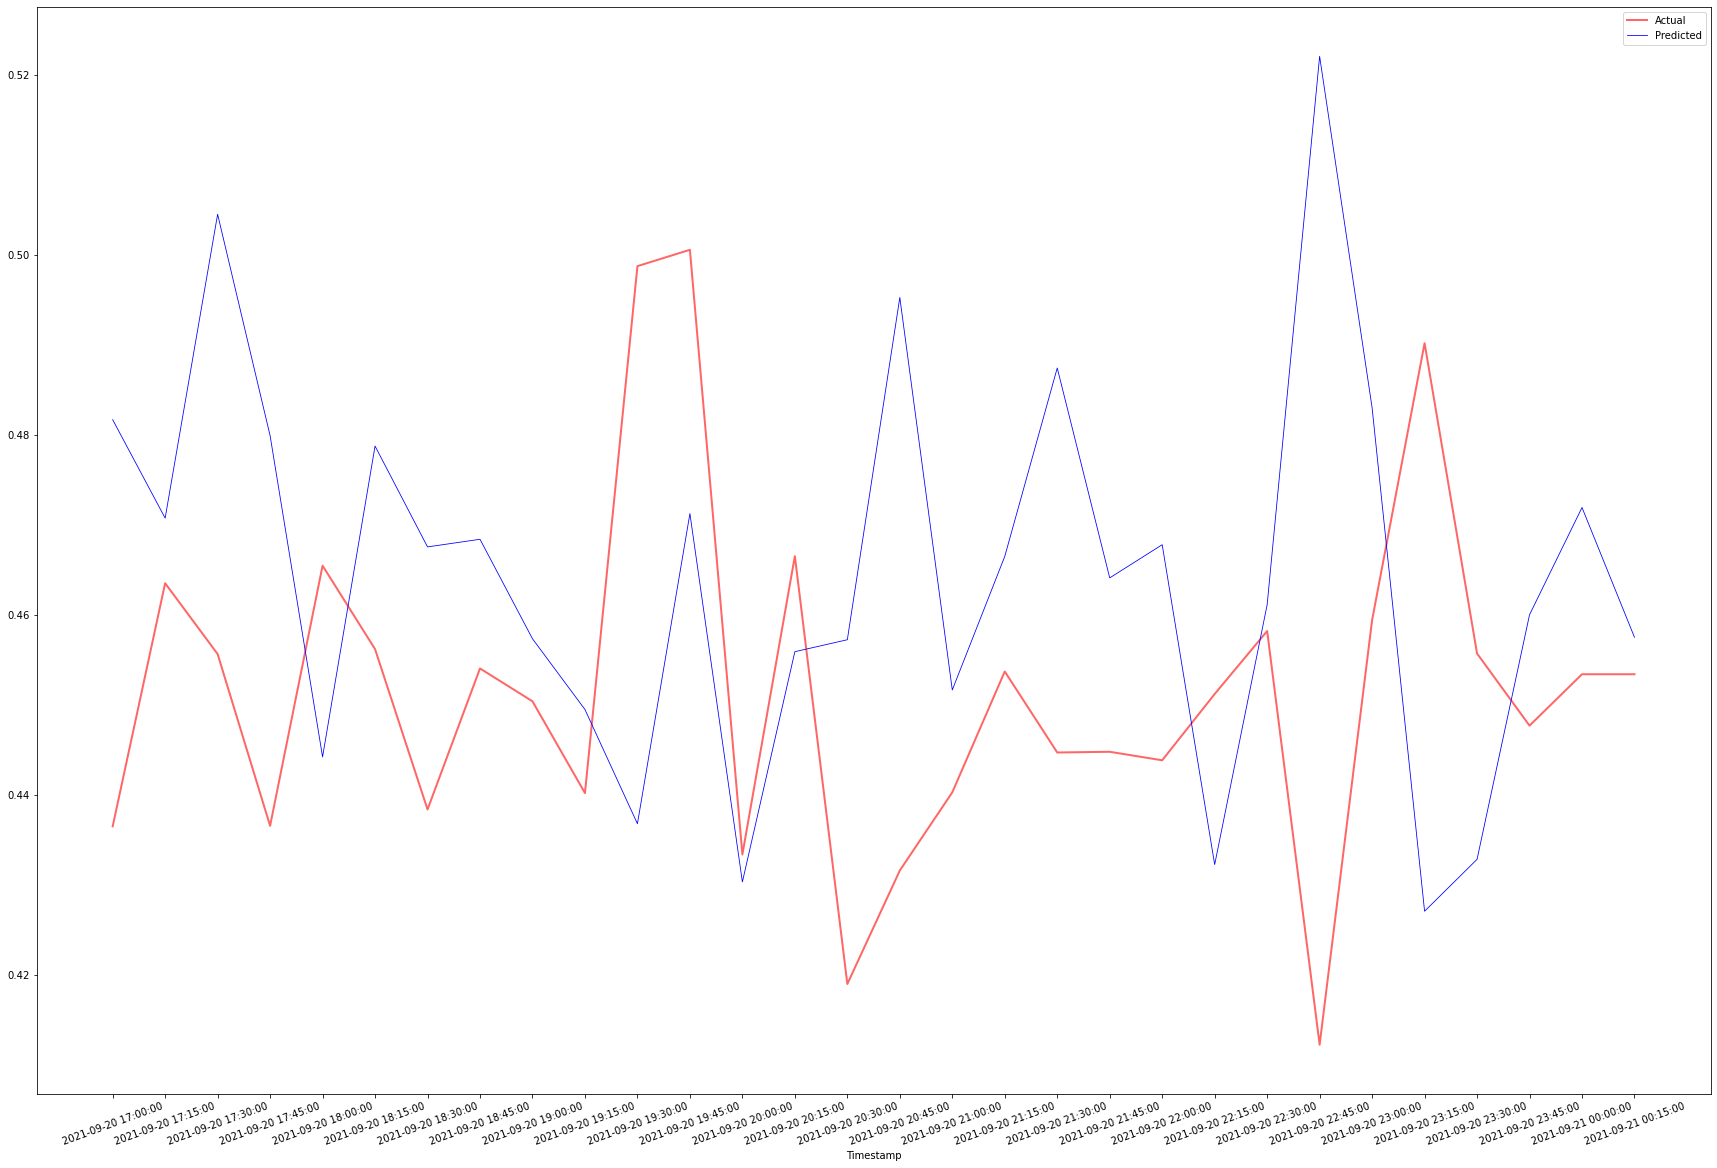

In [33]:
plt.figure(figsize=(30,20))
plt.plot(test_timestamps[-30:], y_test[-30:], color = 'red', linewidth=2.0, alpha = 0.6)
plt.plot(test_timestamps[-30:], y_test_pred[-30:], color = 'blue', linewidth=0.8)
plt.legend(['Actual','Predicted'])
plt.xlabel('Timestamp')
plt.xticks(rotation=20)
plt.show()

## Hyperparameter tuning

In [30]:
# calculating different regression metrics

from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV
param_dist = {"max_depth": [1,3,5,7,9,11,13],
              "splitter":["best","random"],
              "max_features":["auto","log2","sqrt",None] ,
              "max_leaf_nodes":[None,10,20,30,40,50,60,70,80,90],
              "min_weight_fraction_leaf":[0.1,0.2,0.3,0.4,0.5],
              "min_samples_leaf": randint(1, 10)}
np.random.seed(0)
tuning_model=RandomizedSearchCV(model,param_dist,scoring='neg_mean_absolute_percentage_error',cv=3,verbose=3,error_score='raise')

tuning_model.fit(x_train,y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV 1/3] END max_depth=9, max_features=None, max_leaf_nodes=50, min_samples_leaf=1, min_weight_fraction_leaf=0.4, splitter=random;, score=-67655725224.400 total time=   0.0s
[CV 2/3] END max_depth=9, max_features=None, max_leaf_nodes=50, min_samples_leaf=1, min_weight_fraction_leaf=0.4, splitter=random;, score=-0.032 total time=   0.0s
[CV 3/3] END max_depth=9, max_features=None, max_leaf_nodes=50, min_samples_leaf=1, min_weight_fraction_leaf=0.4, splitter=random;, score=-0.025 total time=   0.0s
[CV 1/3] END max_depth=7, max_features=None, max_leaf_nodes=90, min_samples_leaf=4, min_weight_fraction_leaf=0.3, splitter=best;, score=-68098027184.242 total time=   0.1s
[CV 2/3] END max_depth=7, max_features=None, max_leaf_nodes=90, min_samples_leaf=4, min_weight_fraction_leaf=0.3, splitter=best;, score=-0.032 total time=   0.1s
[CV 3/3] END max_depth=7, max_features=None, max_leaf_nodes=90, min_samples_leaf=4, min_weight_fraction

RandomizedSearchCV(cv=3, error_score='raise', estimator=DecisionTreeRegressor(),
                   param_distributions={'max_depth': [1, 3, 5, 7, 9, 11, 13],
                                        'max_features': ['auto', 'log2', 'sqrt',
                                                         None],
                                        'max_leaf_nodes': [None, 10, 20, 30, 40,
                                                           50, 60, 70, 80, 90],
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f00e2cbd9d0>,
                                        'min_weight_fraction_leaf': [0.1, 0.2,
                                                                     0.3, 0.4,
                                                                     0.5],
                                        'splitter': ['best', 'random']},
                   scoring='neg_mean_absolute_percentage_error', verbose=3)

In [31]:
tuning_model.best_params_

{'max_depth': 3,
 'max_features': 'log2',
 'max_leaf_nodes': None,
 'min_samples_leaf': 5,
 'min_weight_fraction_leaf': 0.4,
 'splitter': 'best'}

In [34]:
tuned_hyper_model= DecisionTreeRegressor(max_depth=3,max_features='log2',max_leaf_nodes=None,min_samples_leaf=5,min_weight_fraction_leaf=0.4,splitter='best')

tuned_hyper_model.fit(x_train,y_train)

DecisionTreeRegressor(max_depth=3, max_features='log2', min_samples_leaf=5,
                      min_weight_fraction_leaf=0.4)

In [35]:
tuned_hyper_model.fit(x_train, y_train[:,0])

DecisionTreeRegressor(max_depth=3, max_features='log2', min_samples_leaf=5,
                      min_weight_fraction_leaf=0.4)

In [36]:
y_train_pred1 = tuned_hyper_model.predict(x_train).reshape(-1,1)
y_test_pred1 = tuned_hyper_model.predict(x_test).reshape(-1,1)

print(y_train_pred1.shape, y_test_pred1.shape)

(91388, 1) (38974, 1)


In [37]:
train_timestamps1 = df[(df.index < test_start_dt) & (df.index >= train_start_dt)].index[timesteps-1:]
test_timestamps1 = df[test_start_dt:].index[timesteps-1:]

print(len(train_timestamps1), len(test_timestamps1))

91388 38974


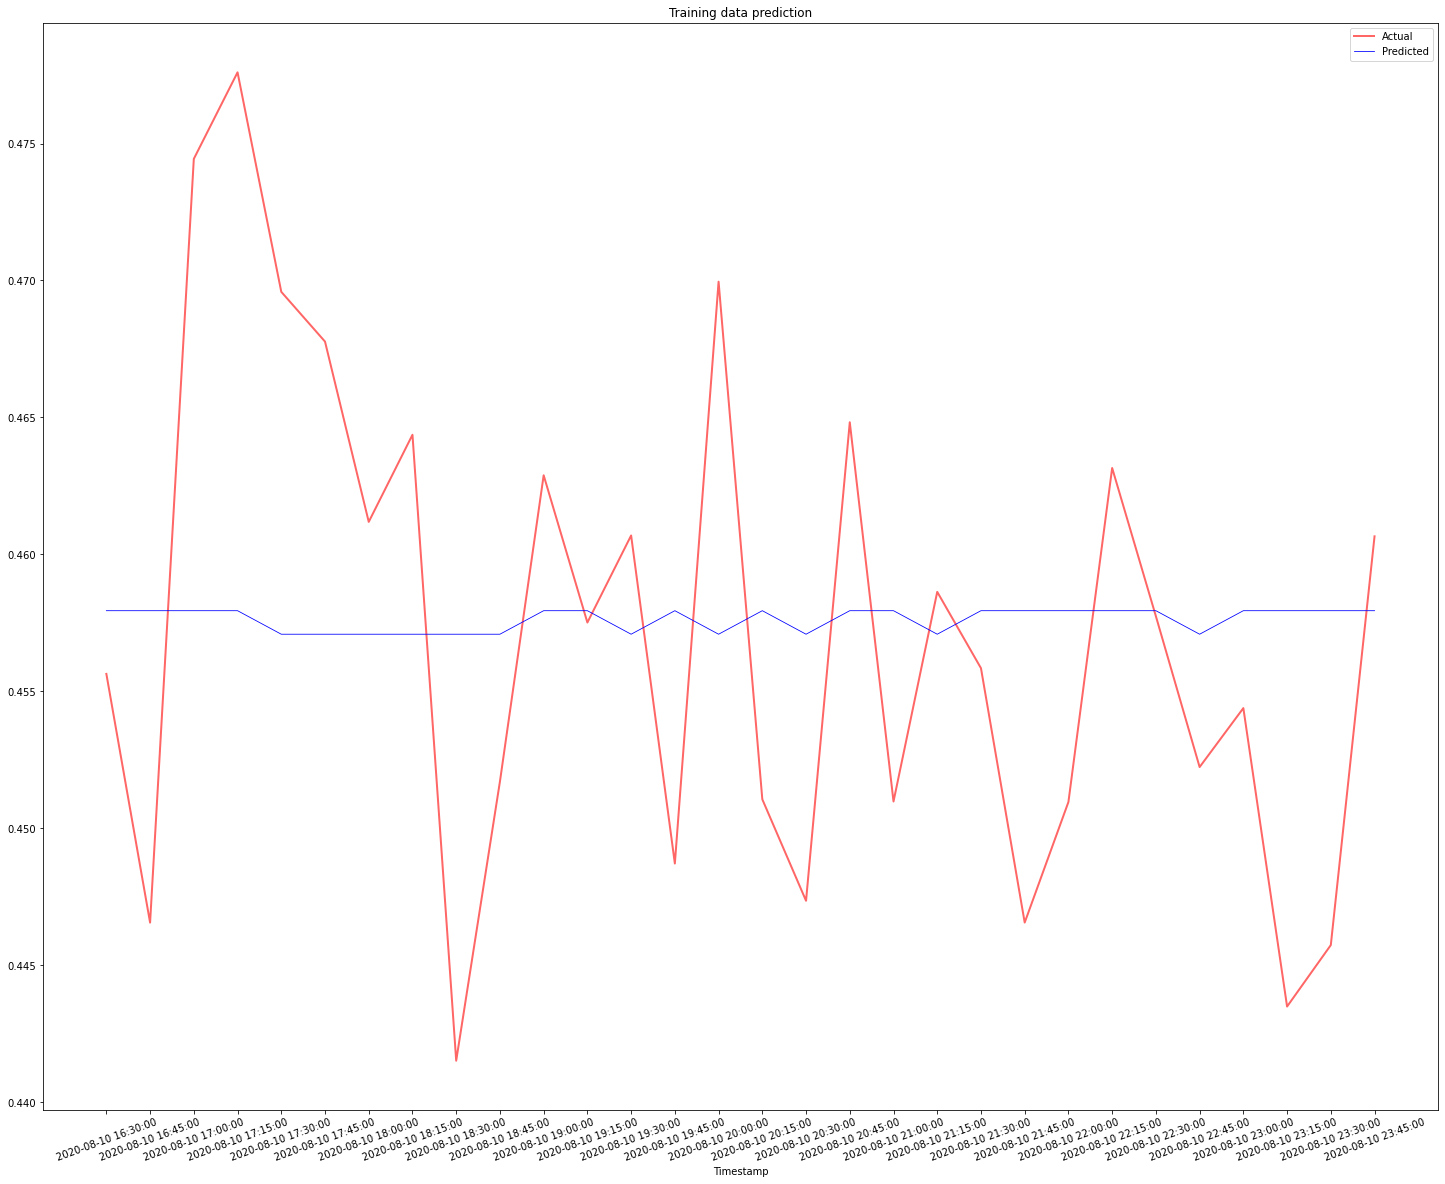

In [38]:
#Visulising the actual vs predicted for the last 30 values in the Train data
plt.figure(figsize=(25,20))
plt.plot(train_timestamps1[-30:], y_train[-30:], color = 'red', linewidth=2.0, alpha = 0.6)
plt.plot(train_timestamps1[-30:], y_train_pred1[-30:], color = 'blue', linewidth=0.8)
plt.legend(['Actual','Predicted'])
plt.xlabel('Timestamp')
plt.xticks(rotation=20)
plt.title("Training data prediction")
plt.show()

In [39]:
#test MAPE 
mean_absolute_percentage_error1(y_test,y_test_pred1)

3.7064060481612704

In [40]:
#TRAIN MAPE 
mean_absolute_percentage_error1(y_train,y_train_pred1)

2.9954566046819435

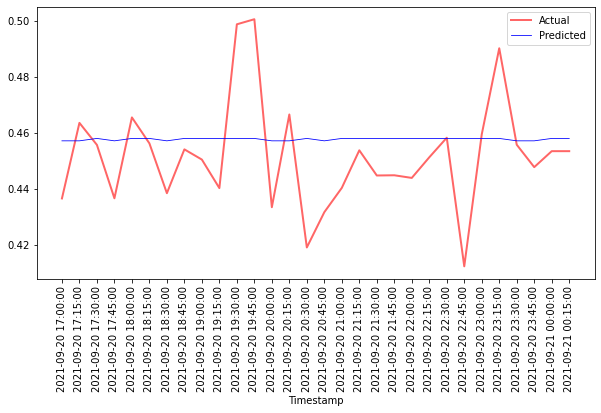

In [41]:
#Visulising the actual vs predicted for the last 30 values in the TEST data
plt.figure(figsize=(10,5))
plt.plot(test_timestamps[-30:], y_test[-30:], color = 'red', linewidth=2.0, alpha = 0.6)
plt.plot(test_timestamps[-30:], y_test_pred1[-30:], color = 'blue', linewidth=0.8)
plt.legend(['Actual','Predicted'])
plt.xlabel('Timestamp')
plt.xticks(rotation=90)
plt.show()

In [42]:
print('MSE:', mean_squared_error(y_test, y_test_pred1))
print('RMSE:', np.sqrt(mean_squared_error(y_test, y_test_pred1)))

MSE: 0.0006801290889843668
RMSE: 0.026079284671638652


In [43]:
print('MSE:', mean_squared_error(y_train, y_train_pred1))
print('RMSE:', np.sqrt(mean_squared_error(y_train, y_train_pred1)))

MSE: 0.00046509297925773156
RMSE: 0.021566014450002845


The train MAPE is 2.995 and Test MAPE is 3.706. As can be seen from the above graph that DT are able to only predict the trend and not the non-linear structure.